# Preprocessing steps for Raman data

1. Data merging
2. Baseline correction


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from numpy.polynomial.polynomial import Polynomial
%config InlineBackend.figure_format = 'svg'

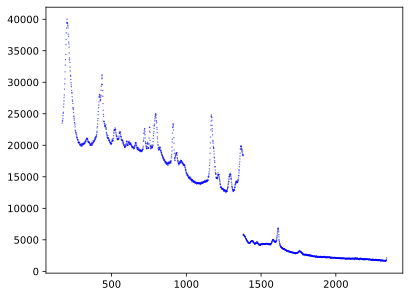

In [22]:
data = [list(map(float, line.split())) for line in open('Data/corrected/6/155.txt')]
x, y = zip(*data)

plt.scatter(x, y, facecolors='none', edgecolors='blue', s=0.1, marker='o')
plt.show()

🔧 Enforced baseline ≤ signal at 138 points.
✅ No negatives detected. No shift needed.


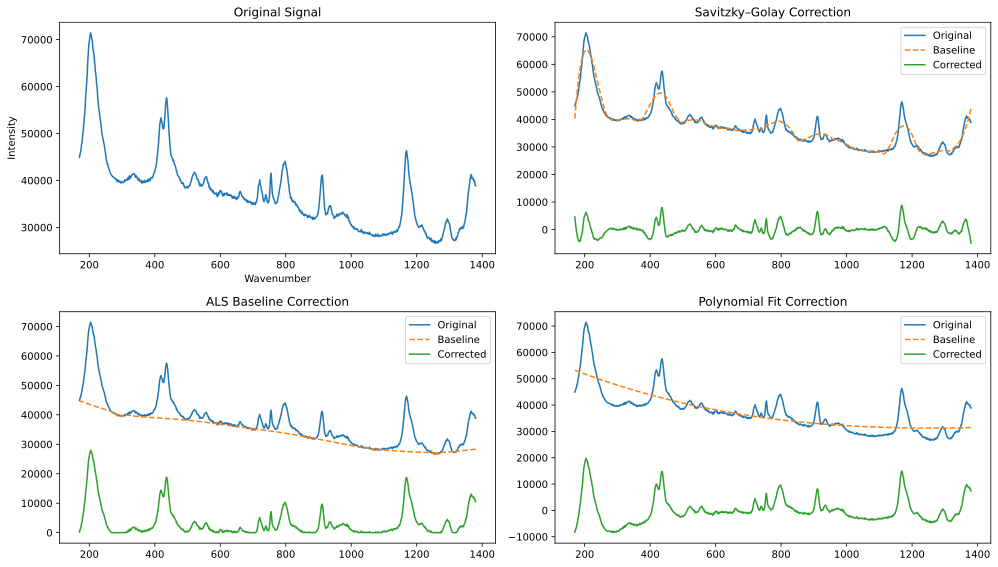

In [14]:
# ---------- Load Your Raman Data ----------
# Replace with your actual path
data = np.loadtxt('Data/5-1/(5)-11_0__X_4.2__Y_35.4__ElapsedTime_0.txt', skiprows=0)  # change filename if needed

x = data[:, 0]  # Wavenumber (X-axis)
y = data[:, 1]  # Intensity (Y-axis)

# ---------- 1. Savitzky–Golay Baseline ----------
def baseline_savgol(y, window=101, poly=3):
    baseline = savgol_filter(y, window_length=window, polyorder=poly)
    return y - baseline, baseline

# ---------- 2. ALS Baseline ----------
def baseline_als_final(y, lam=1e6, p=0.01, niter=10, debug=False):
    """
    Final version of ALS baseline correction:
    - Allows full ALS freedom
    - Ensures baseline doesn't overshoot signal
    - Checks final corrected signal for negatives and shifts baseline if needed
    """
    from scipy import sparse
    from scipy.sparse.linalg import spsolve
    import numpy as np

    y = np.array(y)
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    w = np.ones(L)

    # Step 1: Run standard ALS
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D @ D.T
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)

    # Step 2: Enforce baseline stays below signal
    mask = z > y
    if np.any(mask):
        z[mask] = y[mask]
        if debug:
            print(f"🔧 Enforced baseline ≤ signal at {np.sum(mask)} points.")

    corrected = y - z

    # Step 3: Final safety — correct if any negatives remain
    if np.any(corrected < 0):
        min_val = np.min(corrected)
        z += abs(min_val)
        corrected = y - z
        if debug:
            print(f"✅ Final adjustment: shifted baseline by {abs(min_val):.4f} to remove negatives.")

    else:
        if debug:
            print("✅ No negatives detected. No shift needed.")

    return corrected, z


# ---------- 3. Polynomial Fit ----------
def baseline_poly(x, y, deg=3):
    coeffs = Polynomial.fit(x, y, deg).convert().coef
    baseline = np.polyval(list(reversed(coeffs)), x)
    return y - baseline, baseline

# ---------- Apply Corrections ----------
y_savgol, b_sg = baseline_savgol(y)
y_als, b_als = baseline_als_final(y, debug=True)
y_poly, b_poly = baseline_poly(x, y)

# ---------- Plot Comparison ----------
plt.figure(figsize=(14, 8))

# Original
plt.subplot(2, 2, 1)
plt.plot(x, y, label='Original')
plt.title("Original Signal")
plt.xlabel("Wavenumber")
plt.ylabel("Intensity")

# Savitzky–Golay
plt.subplot(2, 2, 2)
plt.plot(x, y, label='Original')
plt.plot(x, b_sg, '--', label='Baseline')
plt.plot(x, y_savgol, label='Corrected')
plt.title("Savitzky–Golay Correction")
plt.legend()

# ALS
plt.subplot(2, 2, 3)
plt.plot(x, y, label='Original')
plt.plot(x, b_als, '--', label='Baseline')
plt.plot(x, y_als, label='Corrected')
plt.title("ALS Baseline Correction")
plt.legend()

# Polynomial Fit
plt.subplot(2, 2, 4)
plt.plot(x, y, label='Original')
plt.plot(x, b_poly, '--', label='Baseline')
plt.plot(x, y_poly, label='Corrected')
plt.title("Polynomial Fit Correction")
plt.legend()

plt.tight_layout()
plt.show()


Future work: There is a problem of ALS with negative values. Yes, there is no negative values anymore but it seems like it is overfitting at that parts.
1. Be sure there is no negative balues for the intensity
2. Be sure it is not overfitting, capturing the general trends 
3. Be sure that this ALS baseline correction works properly for all the other Raman data